# Clustering

## Load data
Four objects are loaded:
1. 'data/prepped.pkl' is a pickled dataframe containing cleaned comments and their subreddit label
2. LSA, pLSA, and LDA are numpy arrays containing several features (taking the form of a real number) extracted from each comment. These are the versions with comments agglomerated by subreddit.

In [1]:
import numpy as np
import pandas as pd
from time import time
import pickle

print("Importing data...")
t0 = time()
data_comments = pd.read_pickle('data/prepped.pkl')
data = pd.read_pickle('data/prepped_sub.pkl')
LSA = np.load('data/X_LSA_sub.npy')
pLSA = np.load('data/X_pLSA_sub.npy')
LDA = np.load('data/X_LDA_sub.npy')
doc2vec = np.load('data/doc2vec_sub.npy')
print("done in %0.3fs" % (time()-t0))

# assert(data.shape[0] == LSA.shape[0])
# assert(data.shape[0] == pLSA.shape[0])
# assert(data.shape[0] == LDA.shape[0])


Importing data...
done in 2.419s


## Clulstering method evaluation
Clustering methods are compared for each feature extraction method.
1. A memory-efficient KMeans algorithm
2. Birch, a memory-efficient, tree-based method

They are compared using the average of the Silhouette scores.

In [2]:
from sklearn.cluster import MiniBatchKMeans, Birch
from sklearn.metrics import silhouette_score
from sklearn.model_selection import KFold

n_samples = data.shape[0]
splits=[]
for split, _ in KFold(n_splits=5).split(range(n_samples)):
    splits.append(split)

extractors = [
    ("LSA", LSA),
    ("pLSA", pLSA),
    ("LDA", LDA),
    ("doc2vec", doc2vec)
]

rec_range = range(5,105,5)

results = {'extractor'      : np.array([], dtype='object'),
           'n_recommended'  : np.array([], dtype='float64'),
           'clusterer'      : np.array([], dtype='float64'),
           'fit_time'       : np.array([], dtype='float64'),
           'pred_time'      : np.array([], dtype='float64'),
           'score_time'     : np.array([], dtype='float64'),
           'score'          : np.array([], dtype='float64'),
           'fit_time_std'   : np.array([], dtype='float64'),
           'pred_time_std'  : np.array([], dtype='float64'),
           'score_time_std' : np.array([], dtype='float64'),
           'score_std'      : np.array([], dtype='float64'),
          }

counts = len(extractors)*20
count = 0
overall_time = time()
for ex_name, X in extractors:
    for n_recommended in rec_range:
        n_clusters = round(n_samples / n_recommended)
        
        clusterers = [
            ('kmeans', MiniBatchKMeans(n_clusters=n_clusters)),
            ('birch', Birch(threshold=0.01, branching_factor=50, n_clusters=n_clusters))
        ]
        
        for cl_name, clusterer in clusterers:
            var1 = []
            var2 = []
            var3 = []
            var4 = []
            for ind in splits:
                t0 = time()
                clusterer.fit(X[ind])
                t1 = time()
                preds = clusterer.predict(X[ind])
                t2 = time()
                score = silhouette_score(X[ind], preds, metric='cosine') #, sample_size=round(0.01*n_samples), random_state=0)
                t3 = time()
                var1.append((t1-t0))
                var2.append((t2-t1))
                var3.append((t3-t2))
                var4.append(score)
            
            results['extractor']= np.append(results['extractor'], ex_name)
            results['n_recommended'] = np.append(results['n_recommended'], n_recommended)
            results['clusterer'] = np.append(results['clusterer'], cl_name)
            results['fit_time'] = np.append(results['fit_time'], np.mean(var1))
            results['pred_time'] = np.append(results['pred_time'], np.mean(var2))
            results['score_time'] = np.append(results['score_time'], np.mean(var3))
            results['score'] = np.append(results['score'], np.mean(var4))
            results['fit_time_std'] = np.append(results['fit_time_std'], np.std(var1))
            results['pred_time_std'] = np.append(results['pred_time_std'], np.std(var2))
            results['score_time_std'] = np.append(results['score_time_std'], np.std(var3))
            results['score_std'] = np.append(results['score_std'], np.std(var4))
        
        count = count + 1
        # print("Percent complete: %0d, Elapsed time: %0.1f minutes" % (round(count/counts*100), ((time()-overall_time)/60)))

print()
print("Total Elapsed time: %0.1f" % ((time()-overall_time)/60))


C:\Users\sfzba\Anaconda3\lib\site-packages\sklearn\cluster\birch.py:629: UserWarning: Number of subclusters found (96) by Birch is less than (200). Decrease the threshold.
  % (len(centroids), self.n_clusters))
C:\Users\sfzba\Anaconda3\lib\site-packages\sklearn\cluster\birch.py:629: UserWarning: Number of subclusters found (121) by Birch is less than (200). Decrease the threshold.
  % (len(centroids), self.n_clusters))
C:\Users\sfzba\Anaconda3\lib\site-packages\sklearn\cluster\birch.py:629: UserWarning: Number of subclusters found (131) by Birch is less than (200). Decrease the threshold.
  % (len(centroids), self.n_clusters))
C:\Users\sfzba\Anaconda3\lib\site-packages\sklearn\cluster\birch.py:629: UserWarning: Number of subclusters found (132) by Birch is less than (200). Decrease the threshold.
  % (len(centroids), self.n_clusters))
C:\Users\sfzba\Anaconda3\lib\site-packages\sklearn\cluster\birch.py:629: UserWarning: Number of subclusters found (129) by Birch is less than (200). Decr


Total Elapsed time: 4.2


In [16]:
continuous, integral, categorical = (results['n_recommended'], results['extractor'], results['clusterer'])
mask = categorical=='birch'
continuous, integral, categorical, score, score_std, fit_time, fit_time_std = (continuous[mask], integral[mask], categorical[mask], results['score'][mask], results['score_std'][mask], results['fit_time'][mask], results['fit_time_std'][mask])


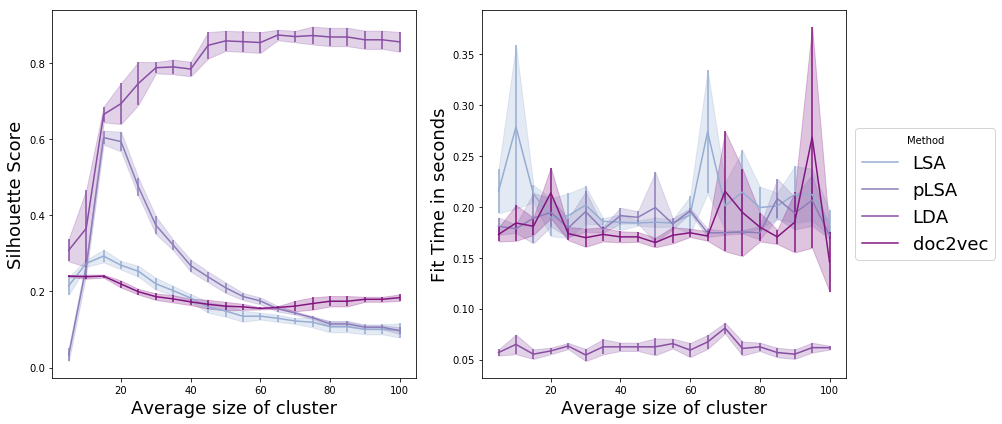

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
plt.ioff()

# For each subplot, define [var, var_std, xlabel, ylabel, title, legend?]
plot_array = [
    [score, score_std, "Average size of cluster", "Silhouette Score", "", False], # Showing legends on leftmost plot shows which integral values are present for each categorical value
    [fit_time, fit_time_std, "Average size of cluster", "Fit Time in seconds", "", False],
#    [results['pred_time'], results['pred_time_std'], "Average size of cluster", "Prediction Time in seconds", "", False],
#    [results['score_time'], results['score_time_std'], "Average size of cluster", "Score Time in seconds", "", False],
]

# Set colormap
scalarMap = mplcm.ScalarMappable(norm=colors.Normalize(vmin=-3, 
                                                       vmax=len(np.unique(integral))), 
                                 cmap=plt.get_cmap('BuPu'))

fs = 18

# Define legend for all values of integral
fig_t = plt.figure();
color_ints = {}
for i, lab in enumerate(['LSA','pLSA','LDA','doc2vec']): #np.unique(integral)):
    color_ints[lab] = i
    plt.plot([],[],label=lab, color=scalarMap.to_rgba(i))
handles, labels = fig_t.axes[0].get_legend_handles_labels()
plt.close(fig_t);

dim_h = len(plot_array)             # horizontal number of subplots
dim_v = len(np.unique(categorical)) # vertical number of subplots
p = 0                               # subplot count
fig = plt.figure(figsize=[12,6]);
for i in np.unique(categorical):
    vals_used = ['LSA','pLSA','LDA','doc2vec'] #np.unique(integral[categorical == i])
    for j in range(dim_h):
        p = p+1
        ax = fig.add_subplot(dim_v, dim_h, p);
        for k in vals_used:
            mask = np.logical_and(categorical == i, integral == k)
            x = np.array(continuous[mask], dtype='float64') # *SearchCV uses dtype 'object'
            ind_sort = np.argsort(x) # order by x values for line plot
            x = x[ind_sort]
            y = plot_array[j][0][mask][ind_sort]
            y_stds = plot_array[j][1][mask][ind_sort]
            # Show line plot with error bars
            _ = plt.errorbar(x, y, yerr=y_stds, label=k, color=scalarMap.to_rgba(color_ints[k]))
            # Show confidence interval as shaded region
            _ = plt.fill_between(x, y - y_stds, y + y_stds, color=scalarMap.to_rgba(color_ints[k]), alpha=.25)
        
        _ = plt.xlabel(plot_array[j][2], fontsize=fs);
        _ = plt.ylabel(plot_array[j][3], fontsize=fs);
#         if j==0:
#             subtitle=("%s clustering" % i)
#         else:
#             subtitle=""
#         _ = plt.title(subtitle+plot_array[j][4], fontsize=fs);
#         if plot_array[j][5]:
#             _ = plt.legend(loc='upper left', fontsize=fs);
# Add legends to right of plots
for i in range(int(p/dim_h)):
    fig.axes[(i+1)*dim_h-1].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Method", fontsize=fs)

plt.tight_layout()
plt.show()


## Clustering analysis

In [18]:
from sklearn.cluster import MiniBatchKMeans, Birch
from sklearn.metrics import silhouette_score

n_samples = data.shape[0]
n_recommended = 15
n_clusters = round(n_samples / n_recommended)

extractors = [
    ("LSA", LSA),
    ("pLSA", pLSA),
    ("LDA", LDA),
    ("doc2vec", doc2vec)
]

clusterers = [
    ("kmeans", MiniBatchKMeans(n_clusters=n_clusters, # 8
                               init='k-means++', 
                               max_iter=100, 
                               batch_size=100, 
                               verbose=0, 
                               compute_labels=True, 
                               random_state=0, # None
                               tol=0.0, 
                               max_no_improvement=10, 
                               init_size=(3*n_clusters), # None
                               n_init=3, 
                               reassignment_ratio=0.01, 
                              ) ),
    ("birch", Birch(threshold=0.05,
                    branching_factor=50, 
                    n_clusters=n_clusters, 
                    compute_labels=True, 
                    copy=True,
                   ) ),
]

ex_preds = {}
for ex_name, X in extractors:
    print(ex_name)
    print()
    
    cl_preds = {}
    for cl_name, clusterer in clusterers:    
        print(cl_name)
        t0 = time()
        clusterer.fit(X)
        t1 = time()
        preds = clusterer.predict(X)
        t2 = time()
        score = silhouette_score(X, preds) #, sample_size=round(0.01*n_samples), random_state=0)
        t3 = time()
        
        cl_preds[cl_name] = (clusterer, preds, score)
        
        print("Fit time  : %0.3f sec" % (t1-t0))
        print("Pred time : %0.3f sec" % (t2-t1))
        print("Score time: %0.3f sec" % (t3-t2))
        print("Score     : %0.3f" % score)
        print()
    ex_preds[ex_name] = cl_preds


LSA

kmeans
Fit time  : 0.304 sec
Pred time : 0.008 sec
Score time: 0.280 sec
Score     : 0.246

birch
Fit time  : 0.248 sec
Pred time : 0.020 sec
Score time: 0.284 sec
Score     : 0.265

pLSA

kmeans
Fit time  : 0.260 sec
Pred time : 0.008 sec
Score time: 0.260 sec
Score     : 0.359

birch
Fit time  : 0.168 sec
Pred time : 0.008 sec
Score time: 0.280 sec
Score     : 0.420

LDA

kmeans
Fit time  : 0.168 sec
Pred time : 0.008 sec
Score time: 0.288 sec
Score     : 0.321

birch
Fit time  : 0.040 sec
Pred time : 0.000 sec
Score time: 0.116 sec
Score     : 0.609

doc2vec

kmeans


C:\Users\sfzba\Anaconda3\lib\site-packages\sklearn\cluster\birch.py:629: UserWarning: Number of subclusters found (41) by Birch is less than (67). Decrease the threshold.
  % (len(centroids), self.n_clusters))


Fit time  : 0.244 sec
Pred time : 0.008 sec
Score time: 0.248 sec
Score     : 0.114

birch
Fit time  : 0.260 sec
Pred time : 0.020 sec
Score time: 0.268 sec
Score     : 0.133



In [115]:
# Choose model to analyze
_, preds, _ = ex_preds["LSA"]["birch"]


### List subreddits in each cluster

In [116]:
import pprint
for i in range(max(preds)+1):
    pprint.pprint(data.iloc[preds==i,1].tolist())

['NatureIsFuckingLit',
 'AnimalsBeingJerks',
 'woodworking',
 'natureismetal',
 'ThriftStoreHauls',
 'DiWHY',
 'Multicopter',
 'succulents',
 'blackmagicfuckery',
 'educationalgifs',
 'Homebrewing',
 'Coffee',
 'cats',
 'whatisthisthing',
 'Vaping',
 'microgrowery',
 'ElectricSkateboarding',
 'vegan',
 'creepy',
 'electronic_cigarette',
 'HomeImprovement',
 'Ultralight',
 'Eyebleach',
 'Flipping',
 'DIY',
 'dogs',
 'aww',
 'rarepuppers',
 'vaporents',
 'Aquariums',
 'starbucks',
 'gardening',
 'woahdude']
['marvelstudios',
 'DC_Cinematic',
 'DCcomics',
 'comicbooks',
 'TwoBestFriendsPlay',
 'whowouldwin',
 'future_fight',
 'mvci',
 'ContestOfChampions',
 'INJUSTICE',
 'Marvel',
 'StreetFighter',
 'comics',
 'Kappa']
['korea',
 'EarthPorn',
 'brisbane',
 'dataisbeautiful',
 'britishproblems',
 'melbourne',
 'JordanPeterson',
 'TalesFromRetail',
 'evilbuildings',
 'ukpolitics',
 'newzealand',
 'dubai',
 'AskAnAmerican',
 'Futurology',
 'collapse',
 'civ',
 'unitedkingdom',
 'belgium',
 '

In [117]:
pprint.pprint(data.iloc[preds==56,1].tolist())

['Parenting',
 'breakingmom',
 'childfree',
 'BabyBumps',
 'beyondthebump',
 'JUSTNOMIL']


### Wordclouds and frequency distributions

Cluster number 56:
['synthesizers', 'makinghiphop', 'WeAreTheMusicMakers', 'brandnew', 'edmproduction', 'Guitar', 'vinyl', 'guitarpedals', 'headphones']


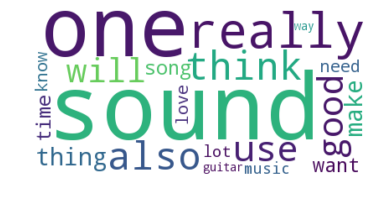

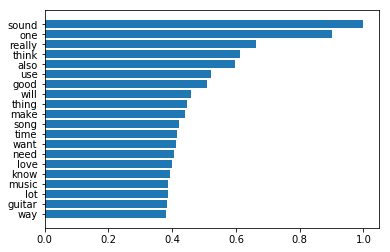

Cluster number 57:
['Kanye', 'TaylorSwift', 'FrankOcean', 'indieheads', 'hiphopheads', 'bangtan', 'Metalcore', 'listentothis', 'Eminem', 'Metal', 'popheads', 'radiohead', 'deathgrips', 'kpop', 'Music']


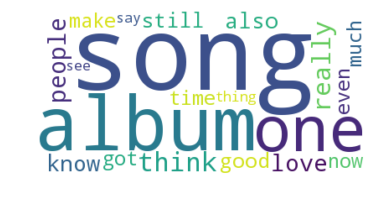

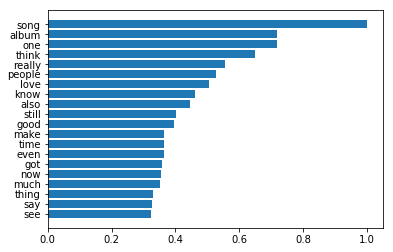

In [77]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
max_words = 20
wc = WordCloud(background_color="white", max_words=max_words)

#for i in range(max(preds)+1):
for i in range(56,58):
    print("Cluster number {}:".format(i))
    print(data.iloc[preds==i,1].tolist())
    wc.generate(data[preds==i].body.str.cat(sep=' '))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    words = []
    freqs = []
    for word in wc.words_:
        if wc.words_[word]!=0:
            words.append(word)
            freqs.append(wc.words_[word])
    x = range(max_words,0,-1)
    plt.barh(x,freqs[:max_words])
    plt.yticks(x, np.asarray(words[:max_words]))
    plt.show()

### tSNE visualization

In [ ]:
does not compile

from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X)
indices = range(max(preds)+1)
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, len(indices)))
for i, color in zip(indices, colors):
    plt.scatter(X_embedded[preds==i,0],X_embedded[preds==i,1],c=color,label=i,alpha=0.5) # 'C{}'.format(i)
# plt.legend()
plt.show()


## Approximate Nearest Neighbors


In [112]:
from annoy import AnnoyIndex

ann_input = LSA

indx = AnnoyIndex(ann_input.shape[1], metric='angular')

print("Building Annoy index...")
t0 = time()
for i, row in enumerate(ann_input):
    indx.add_item(i,row)
indx.build(50)
print("done in %0.3fs" % (time()-t0))


Building Annoy index...
done in 0.156s


In [114]:
subname = 'Fitness'
test_ix = data.index[data.subreddit==subname].tolist()[0]
n_recommended = 6

print("Given /r/%s, I recommend..." % data.iloc[test_ix,1])
ixs, dists = indx.get_nns_by_item(test_ix, n_recommended, search_k=-1, include_distances=True)

for ix, dist in zip(ixs[1:], dists[1:]):
    print(("/r/%s," % data.iloc[ix,1]).ljust(20) + (" at a distance of %0.2f" % dist))

Given /r/Fitness, I recommend...
/r/xxfitness,        at a distance of 0.21
/r/bodybuilding,     at a distance of 0.22
/r/weightroom,       at a distance of 0.36
/r/orangetheory,     at a distance of 0.39
/r/powerlifting,     at a distance of 0.47


## Example of biased unsupervised metric

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score

coords_1 = np.random.multivariate_normal([0,0], [[1.5,0],[0,1]], 100)
coords_2 = np.random.multivariate_normal([2,2], [[1,0.5],[0.5,1.5]], 100)
coords_3 = np.random.multivariate_normal([-2,3], [[0.8,0],[0,1]], 100)

coords = np.append(np.append(coords_1,coords_2,axis=0),coords_3,axis=0)
truth = np.append(np.zeros([100,]), np.append(np.ones([100,]), 2*np.ones([100])))

truth_scores = []
km_scores = []
bi_scores = []
for _ in range(50):
    coords_1 = np.random.multivariate_normal([0,0], [[1.5,0],[0,1]], 100)
    coords_2 = np.random.multivariate_normal([2,2], [[1,0.5],[0.5,1.5]], 100)
    coords_3 = np.random.multivariate_normal([-2,3], [[0.8,0],[0,1]], 100)
    coords = np.append(np.append(coords_1,coords_2,axis=0),coords_3,axis=0)
    
    truth = np.append(np.zeros([100,]), np.append(np.ones([100,]), 2*np.ones([100])))
    truth_scores.append( silhouette_score(coords, truth))
    km_labels = KMeans(3).fit_predict(coords)
    km_scores.append(silhouette_score(coords, km_labels))
    bi_labels = Birch(n_clusters=3, threshold=0.05).fit(coords).predict(coords)
    bi_scores.append(silhouette_score(coords, bi_labels))

print("Silhouette Scores")
print("Truth  : %0.3f +/- %0.3f" % (np.mean(truth_scores), np.std(truth_scores)) )
print("KMeans : %0.3f +/- %0.3f" % (np.mean(km_scores), np.std(km_scores)) )
print("Birch  : %0.3f +/- %0.3f" % (np.mean(bi_scores), np.std(bi_scores)) )

fig = plt.figure(figsize=[5,5])
plt.scatter(coords[truth==0,0],coords[truth==0,1],c='C0')
plt.scatter(coords[truth==1,0],coords[truth==1,1],c='C1')
plt.scatter(coords[truth==2,0],coords[truth==2,1],c='C2')
plt.axis('off')
plt.savefig("presentation/figures/clusters.png", bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=[5,5])
plt.scatter(coords[km_labels==1,0],coords[km_labels==1,1],c='C0')
plt.scatter(coords[km_labels==0,0],coords[km_labels==0,1],c='C1')
plt.scatter(coords[km_labels==2,0],coords[km_labels==2,1],c='C2')
plt.axis('off')
plt.show()

fig = plt.figure(figsize=[5,5])
plt.scatter(coords[bi_labels==0,0],coords[bi_labels==0,1],c='tab:blue')
plt.scatter(coords[bi_labels==1,0],coords[bi_labels==1,1],c='tab:green')
plt.scatter(coords[bi_labels==2,0],coords[bi_labels==2,1],c='tab:orange')
plt.axis('off')
plt.show()

In [ ]:
from sklearn.cluster import MiniBatchKMeans, Birch
from sklearn.metrics import silhouette_score
from sklearn.model_selection import KFold

n_samples = data.shape[0]
for split, _ in KFold(n_splits=5).split(range(n_samples)):
    splits.append(split)

extractors = [
    ("LSA", LSA),
#    ("pLSA", pLSA),
    ("LDA", LDA),
    ("doc2vec", doc2vec)
]

results = {}
for ex_name, X in extractors:
    for n_recommended in range(5,105,5):
        n_clusters = round(n_samples / n_recommended)
        
        clusterers = [
            ('kmeans', MiniBatchKMeans(n_clusters=n_clusters)),
            ('birch', Birch(threshold=0.05, branching_factor=50, n_clusters=n_clusters))
        ]
        
        for cl_name, clusterer in clusterers:
            var1 = []
            var2 = []
            var3 = []
            var4 = []
            for ind in splits:
                t0 = time()
                clusterer.fit(X[ind])
                t1 = time()
                preds = clusterer.predict(X[ind])
                t2 = time()
                score = silhouette_score(X[ind], preds) #, sample_size=round(0.01*n_samples), random_state=0)
                t3 = time()
                var1.append((t1-t0))
                var2.append((t2-t1))
                var3.append((t3-t2))
                var4.append(score)
                
            results[ex_name][cl_name]['fit_time'].append(np.mean(var1))
            results[ex_name][cl_name]['pred_time'].append(np.mean(var2))
            results[ex_name][cl_name]['score_time'].append(np.mean(var3))
            results[ex_name][cl_name]['score'].append(np.mean(var4))
            results[ex_name][cl_name]['fit_time_std'].append(np.std(var1))
            results[ex_name][cl_name]['pred_time_std'].append(np.std(var2))
            results[ex_name][cl_name]['score_time_std'].append(np.std(var3))
            results[ex_name][cl_name]['score_std'].append(np.std(var4))
